## Automatic Detection of Flashing Video Content

In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
from os import listdir, remove
from os.path import isfile, join

image_format = ".jpg"

#### Convert the video into images

In [2]:
# Load video
vidcap = cv2.VideoCapture('pokemon.mp4')

# Function to do the conversion
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite("Converted Images/image" + str(count) + image_format, image)     # save frame as JPG file
    return hasFrames

# Start converting the video
sec = 0
frameRate = 0.04 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

#### Convert the images into a single matrix

In [3]:
# Set the path for images
mypath = '/Users/frafiei3/Desktop/Georgia Tech/Special problems/Code/Converted Images'

# Find all the images in the path
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
onlyfiles = [ f for f in onlyfiles if image_format in f]

# Find the dimension of the images
img_rows, img_cols, _ = cv2.imread(join(mypath,onlyfiles[0])).shape

# Set an empty matrix corresponding to the dimension of images and number of frames
images_gray = np.empty([img_rows, img_cols, len(onlyfiles)], dtype=object)

# Convert RGB images into gray scale images and store them in a single matrix
for n in range(len(onlyfiles)):
    images_gray[:,:,n] = cv2.cvtColor(cv2.imread(join(mypath,onlyfiles[n])), cv2.COLOR_BGR2GRAY)

In [4]:
data = np.array(images_gray,dtype='float64')
data.shape

(192, 320, 292)

In [5]:
# Find the luminance matrix
L = 413.435 * (0.002745 * data + 0.0189623)**2.2
L.shape

(192, 320, 292)

In [6]:
#  Step 1: Compute the brightness difference
deltaL = np.diff(L, axis=2)

# Step 2: Generate the histograms
numBins, numFrames = 10, deltaL.shape[2]
h_positive = np.empty(shape=[numBins, numFrames], dtype=int)
h_negative = np.empty(shape=[numBins, numFrames], dtype=int)
for frame in range(deltaL.shape[2]):
    h_positive[:, frame], bin_edges_positive = np.histogram(deltaL[deltaL[:,:,frame]>=0, frame], bins=numBins, range=(0, deltaL.max()))
    h_negative[:, frame], bin_edges_negative = np.histogram(deltaL[deltaL[:,:,frame]<0, frame], bins=numBins, range=(deltaL.min(), 0))
    

In [7]:
# Step 3 and 4: Compute the average brightness variation
threshold = 0.25 * L.shape[0] * L.shape[1] # minimum number of pixels to define flash area
meanDeltaL_positive = np.zeros(h_positive.shape)
meanDeltaL_negative = np.zeros(h_negative.shape)
out_positive = np.where(h_positive > threshold) # index of positive histograms greater than threshold
out_negative = np.where(h_negative > threshold) # index of negative histograms greater than threshold

def compute_mean_in_range(data, interval):
    idx = np.where(np.logical_and(data>=interval[0], data<interval[1]))
    meanInRange = np.mean(data[idx])
    return meanInRange

for frame in range(meanDeltaL_positive.shape[1]):
    if frame in out_positive[1]:
        idx = np.where(out_positive[1]==frame)
        for i in range(len(idx[0])):
            bin_i = out_positive[0][idx[0][i]]
            binMean = compute_mean_in_range(deltaL[:,:,frame], bin_edges_positive[bin_i:bin_i+2])
            meanDeltaL_positive[bin_i, frame] = binMean
            
    if frame in out_negative[1]:
        idx = np.where(out_negative[1]==frame)
        for i in range(len(idx[0])):
            bin_i = out_negative[0][idx[0][i]]
            binMean = compute_mean_in_range(deltaL[:,:,frame], bin_edges_negative[bin_i:bin_i+2])
            meanDeltaL_negative[bin_i, frame] = binMean
    
meanDeltaL = np.concatenate((meanDeltaL_positive, meanDeltaL_negative), axis=0)

In [8]:
# Find the highest value in the average brightness variation
def compute_value_with_max_abs(meanDeltaL):
    a = np.zeros((meanDeltaL.shape[1],1))
    for frame in range(meanDeltaL.shape[1]):
        a[frame] = max(np.max(meanDeltaL[:,frame]), np.min(meanDeltaL[:,frame]), key=abs)
    return a

maxMeanDeltaL = compute_value_with_max_abs(meanDeltaL)

In [9]:
# Step 5 and 6: accumulate the brightness variation with same sign and find the flashes
def accumulation_function(maxMeanDeltaL):
    accDeltaL = np.zeros(maxMeanDeltaL.shape)
    accDeltaL[0] = maxMeanDeltaL[0]
    acc = maxMeanDeltaL[0]
    for frame in range(len(maxMeanDeltaL)):
        if maxMeanDeltaL[frame]*maxMeanDeltaL[frame-1] < 0:
            acc = 0
        acc = acc + maxMeanDeltaL[frame]
        accDeltaL[frame] = acc
    return accDeltaL

accDeltaL = accumulation_function(maxMeanDeltaL)

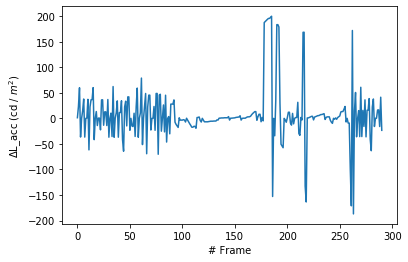

In [10]:
plt.plot(accDeltaL)
plt.xlabel('# Frame')
plt.ylabel('$\Delta$L_acc (cd / $m^2$)')
plt.show()